In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import tensorflow.keras as keras
import tensorflow.keras.backend as K

import os
import os.path as osp
import sys
sys.path.append("/home/jack/projects/EMD_VAE")

import numpy as np
#from scipy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt

# %load_ext autoreload
# %autoreload 2

from utils.tf_sinkhorn import ground_distance_tf_nograd, sinkhorn_knopp_tf_scaling_stabilized_class
import utils.VAE_model_tools
from utils.VAE_model_tools import build_and_compile_annealing_vae, betaVAEModel, reset_metrics

import pandas
import matplotlib.pyplot as plt

import h5py
import pickle


import fastjet as fj
import Nsubjettiness as Nsub
import numpy as np
import pandas as pd

In [6]:
this = np.loadtxt('/home/jack/projects/EMD_VAE/compression_project/data/B_background_1.dat',skiprows=1)

In [7]:
this.shape

(1000000, 6)

In [8]:
this = this[np.abs(this[:,3])<5]

In [9]:
events = [this[this[:,0]==i] for i in range(1000)]

In [10]:
sortedpts = []
htfrac100 = []
htfrac50 = []
for event in events:
    pts = np.flip(np.sort(event[:,2]))
    ht = np.sum(pts)
    htfrac50 += [np.sum(pts[:50])/ht]
    htfrac100 += [np.sum(pts[:100])/ht]

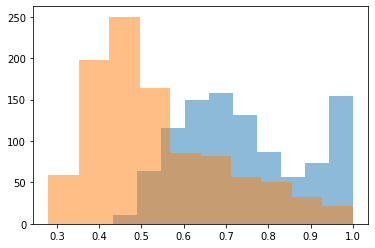

In [11]:
plt.hist(htfrac100,alpha=0.5)
plt.hist(htfrac50,alpha=0.5)
plt.show()

In [49]:
clustered_events = []
frac100 = []
frac50 = []
mjj_0 = []
mj_0 = []
mjj_500 = []
mj_500 = []
mjj_1000 = []
mj_1000 = []

jet_def_big = fj.JetDefinition(fj.antikt_algorithm, 1.0)
jet_def_small = fj.JetDefinition(fj.antikt_algorithm, 1.0)

for event in events:
    
    particles = []

    for particle in event:
        particles += [fj.PtYPhiM(particle[2],particle[3],particle[4],0)]

    sequence_small = fj.ClusterSequence(particles,jet_def_small)
    jets = fj.sorted_by_pt(sequence_small.inclusive_jets(ptmin=0.0))
    sequence_big = fj.ClusterSequence(jets,jet_def_big)
    bigjets = fj.sorted_by_pt(sequence_big.inclusive_jets(ptmin=0.0))
    mjj_0 += [(bigjets[0]+bigjets[1]).m()]
    mj_0 += [bigjets[0].m()]
    mj_0 += [bigjets[1].m()]
    
    sequence_small = fj.ClusterSequence(particles,jet_def_small)
    jets = fj.sorted_by_pt(sequence_small.inclusive_jets(ptmin=0.0))[:100]
    sequence_big = fj.ClusterSequence(jets,jet_def_big)
    bigjets = fj.sorted_by_pt(sequence_big.inclusive_jets(ptmin=0.0))
    mjj_500 += [(bigjets[0]+bigjets[1]).m()]
    mj_500 += [bigjets[0].m()]
    mj_500 += [bigjets[1].m()]
    
#     sequence_small = fj.ClusterSequence(particles,jet_def_small)
#     jets = fj.sorted_by_pt(sequence_small.inclusive_jets(ptmin=0.0))[:50]
#     sequence_big = fj.ClusterSequence(jets,jet_def_big)
#     bigjets = fj.sorted_by_pt(sequence_big.inclusive_jets(ptmin=0.0))
#     if len(bigjets) < 2:
#         continue
#     mjj_1000 += [(bigjets[0]+bigjets[1]).m()]
#     mj_1000 += [bigjets[0].m()]
#     mj_1000 += [bigjets[1].m()]

In [50]:
len(jets)

32

In [86]:
clustered_events = []
frac100 = []
frac50 = []
mjj_0 = []
mj_0 = []
mjj_500 = []
mj_500 = []
mjj_1000 = []
mj_1000 = []

jet_def_big = fj.JetDefinition(fj.antikt_algorithm, 0.4)
jet_def_small = fj.JetDefinition(fj.kt_algorithm, 1.0)

for event in events:
    
    particles = []

    for particle in event:
        particles += [fj.PtYPhiM(particle[2],particle[3],particle[4],0)]

    
    sequence_big = fj.ClusterSequence(particles,jet_def_big)
    bigjets = fj.sorted_by_pt(sequence_big.inclusive_jets(ptmin=0.0))
    mjj_0 += [(bigjets[0]+bigjets[1]).m()]
    mj_0 += [bigjets[0].m()]
    mj_0 += [bigjets[1].m()]
    
    sequence_small = fj.ClusterSequence(particles,jet_def_small)
    jets = fj.sorted_by_pt(sequence_small.exclusive_jets(min(100,len(particles))))
    sequence_big = fj.ClusterSequence(jets,jet_def_big)
    bigjets = fj.sorted_by_pt(sequence_big.inclusive_jets(ptmin=0.0))
    mjj_500 += [(bigjets[0]+bigjets[1]).m()]
    mj_500 += [bigjets[0].m()]
    mj_500 += [bigjets[1].m()]
    
    sequence_small = fj.ClusterSequence(particles,jet_def_small)
    jets = fj.sorted_by_pt(sequence_small.exclusive_jets(min(50,len(particles))))
    sequence_big = fj.ClusterSequence(jets,jet_def_big)
    bigjets = fj.sorted_by_pt(sequence_big.inclusive_jets(ptmin=0.0))
    if len(bigjets) < 2:
        continue
    mjj_1000 += [(bigjets[0]+bigjets[1]).m()]
    mj_1000 += [bigjets[0].m()]
    mj_1000 += [bigjets[1].m()]

In [62]:
len(jets)

50

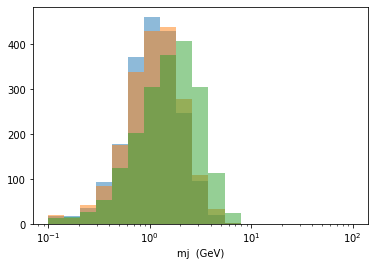

In [88]:
plt.hist(mj_0,alpha=0.5,bins=np.logspace(-1,2,20))
plt.hist(mj_500,alpha=0.5,bins=np.logspace(-1,2,20))
plt.hist(mj_1000,alpha=0.5,bins=np.logspace(-1,2,20))
plt.semilogx()
plt.xlabel("mj  (GeV)")
plt.show()

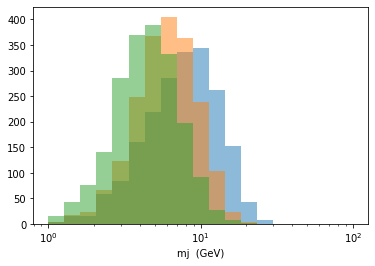

In [44]:
plt.hist(mj_0,alpha=0.5,bins=np.logspace(0,2,20))
plt.hist(mj_500,alpha=0.5,bins=np.logspace(0,2,20))
plt.hist(mj_1000,alpha=0.5,bins=np.logspace(0,2,20))
plt.semilogx()
plt.xlabel("mj  (GeV)")
plt.show()

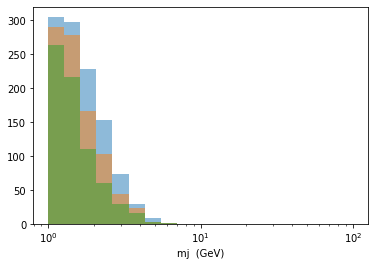

In [79]:
plt.hist(mj_0,alpha=0.5,bins=np.logspace(0,2,20))
plt.hist(mj_500,alpha=0.5,bins=np.logspace(0,2,20))
plt.hist(mj_1000,alpha=0.5,bins=np.logspace(0,2,20))
plt.semilogx()
plt.xlabel("mj  (GeV)")
plt.show()

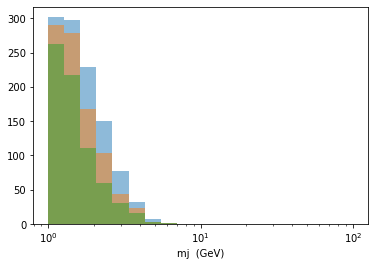

In [85]:
plt.hist(mj_0,alpha=0.5,bins=np.logspace(0,2,20))
plt.hist(mj_500,alpha=0.5,bins=np.logspace(0,2,20))
plt.hist(mj_1000,alpha=0.5,bins=np.logspace(0,2,20))
plt.semilogx()
plt.xlabel("mj  (GeV)")
plt.show()

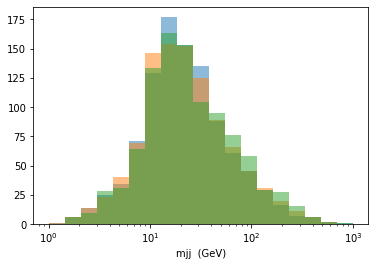

In [91]:
plt.hist(mjj_0,alpha=0.5,bins=np.logspace(0,3,20))
plt.hist(mjj_500,alpha=0.5,bins=np.logspace(0,3,20))
plt.hist(mjj_1000,alpha=0.5,bins=np.logspace(0,3,20))
plt.semilogx()
plt.xlabel("mjj  (GeV)")
plt.show()

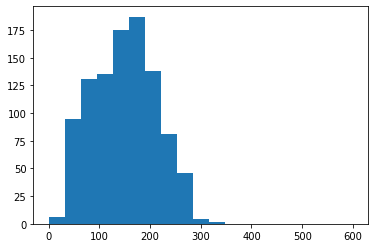

In [81]:
plt.hist(numparticles,bins=np.linspace(0,600,20))
plt.show()

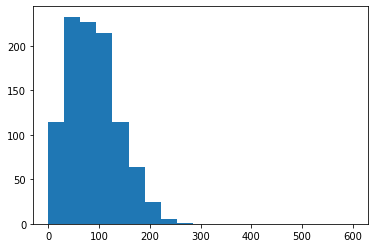

In [72]:
plt.hist(numparticles,bins=np.linspace(0,600,20))
plt.show()

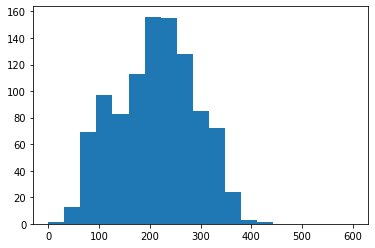

In [50]:
plt.hist(numparticles,bins=np.linspace(0,600,20))
plt.show()

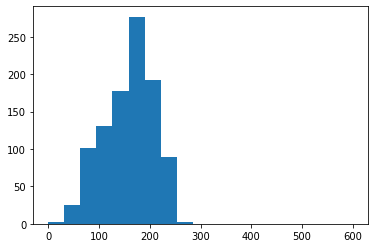

In [53]:
plt.hist(numparticles,bins=np.linspace(0,600,20))
plt.show()

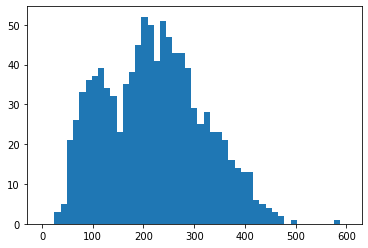

In [66]:
plt.hist(numparticles,bins=np.linspace(0,600,50))
plt.xlim
plt.show()